In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
from os.path import exists

global count
global count2
count = 0
count2 =0

class Metropolis:
    def __init__(self,L,J=1,B=0,isTinf=False):
        self.L = L
        self.N = L*L
        self.J = J
        self.B = B
        count1 = 0
        count2 = 0
        
        self.sc = np.ones(self.N,dtype=np.int0)
        if(isTinf):
            self.sc = np.array([1-(int)(np.random.rand()*2)*2 for i in range(self.N)],dtype=np.int0)
        self.prob = np.zeros(2,dtype=np.double)

    def prob_calc(self,beta):
        for i in range(2):
            # 4 8
            self.prob[i] = np.exp(-beta*4*(i+1))

    def measure(self,func):
        res = 0
        # print(self.sc)
        for i in range(self.N):
            sum = func(i)
            res += self.J*sum*self.sc[i]

        sigma = np.sum(self.sc)
        HH = -res -self.B*sigma

        return sigma, HH

    def helical(self,i):
        sum = 0

        nn = i + 1
        if(nn == self.N): nn = 0
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum

    
    def sweep_pbc(self,i):
        sum = 0

        nn = i -1
        if((nn+1 % self.L) == 0) : nn += self.L
        sum += self.sc[nn]

        nn = i + 1
        if(nn % self.L == 0): nn -= self.L
        sum += self.sc[nn]

        nn = i - self.L
        if(nn < 0): nn += self.N
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum
    
    def sweep_helical(self,i):
        sum = 0

        nn = i -1
        if(nn < 0) : nn += self.N
        sum += self.sc[nn]

        nn = i + 1
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]

        nn = i - self.L
        if(nn < 0): nn += self.N
        sum += self.sc[nn]

        nn = i + self.L
        if(nn >= self.N): nn -= self.N
        sum += self.sc[nn]
        return sum

    def calculate(self,random=False):
        global count, count2
        for i in range(self.N):
            if(random):
                k = np.random.randint(0,self.N-1)
            elif (self.N%2 ==0):
                k = 2*i
                if(k < self.N): k = k if int(k/self.L)%2 ==0 else k+1
                else:
                    k -= self.N
                    k = k+1 if int(k/self.L)%2 ==0 else k
            else:
                k = 2*i if 2*i < self.N else 2*i-self.N
            # print(k,'')

            # delta = Enew - Eold
            delta = 2*self.sc[k]*self.J*self.sweep_helical(k)
            count2 += 1
            # print(delta)
            if(delta <= 0): # A = 1
                count += 1
                self.sc[k] *= -1
            elif(np.random.rand() < self.prob[int(delta/4)-1]): #flip
                # print(delta, self.prob[int(delta/4)-1])
                count += 1
                self.sc[k] *= -1
        return 2*self.sc[k], delta

    def calculate2(self,random=False):
        global count, count2
        for i in range(self.N):
            k = i ## 순서대로 하고 있었네?
            if(random):
                k = np.random.randint(self.N)
            # delta = Enew - Eold
            delta = 2*self.sc[k]*self.J*self.sweep_pbc(k)
            count2 += 1
            # print(delta)
            if(delta <= 0): # A = 1
                count += 1
                self.sc[k] *= -1
            elif(np.random.rand() < self.prob[int(delta/4)-1]): #flip
                # print(delta, self.prob[int(delta/4)-1])
                count += 1
                self.sc[k] *= -1
        return 2*self.sc[k], delta

In [7]:
import os
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

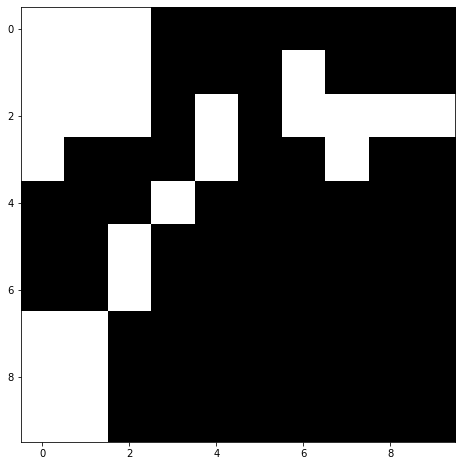

In [14]:
N = 10
T = 2.7
mcs = 10

T11 = Metropolis(N)
T11.prob_calc(1/T)

files = []

fig = plt.figure(figsize=(8,8))
a = np.reshape(T11.sc,(T11.L,T11.L))
plt.imshow(a,cmap="gray")
# fname = '_tmp000.png'
# plt.savefig(fname)
# files.append(fname)

for i in range(mcs):
    plt.cla()
    T11.calculate()
    a = np.reshape(T11.sc,(T11.L,T11.L))
    plt.imshow(a,cmap="Greys")
    fname = '_tmp%03d.png' % i
    plt.savefig(fname)
    files.append(fname)

subprocess.call("mencoder 'mf://_tmp*.png' -mf type=png:fps=10 -ovc lavc "
                "-lavcopts vcodec=wmv2 -oac copy -o animation.mpg", shell=True)

for fname in files:
    os.remove(fname)

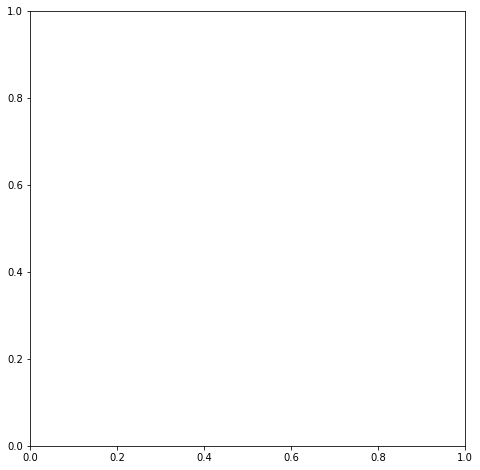

In [44]:
N = 10
T = 1.9
mcs = 100

T11 = Metropolis(N)
T11.prob_calc(1/T)

files = []

fig = plt.figure(figsize=(8,8))
a = np.reshape(T11.sc,(T11.L,T11.L))
# plt.axis('off')
# im = plt.imshow(a,cmap="gray")

def init():
    global im
    a = np.reshape(T11.sc,(T11.L,T11.L))
    im = plt.imshow(a,cmap='gray')
    # return im,

def updateFrame(k):
    global im
    plt.cla()
    T11.calculate()
    a = np.reshape(T11.sc,(T11.L,T11.L))
    im.set_data(a)
    # print(a)
    # im = plt.imshow(a,cmap='Greys')

    
ani = FuncAnimation(fig, updateFrame,frames=mcs, init_func=init, interval=50)
ani.save("temp.avi",dpi=600)
plt.show()

In [ ]:
img = None
for f in files:
    im=plt.imread(f)
    if img is None:
        img = plt.imshow(im)
    else:
        img.set_data(im)
    plt.pause(.1)
    plt.draw()

In [ ]:
# Figure for equilibrium
def Equilibrium_drawer(T,factor = 1, mcs = 1000, N=100):
    T11 = Metropolis(N)
    T11.prob_calc(1/T)
    ls , mcs = np.array([10,20,40,60,100,200,400,1000,10000]), mcs
    ls , mcs = factor*ls, factor*mcs
    # ls = [1,2,4,6,10,20,40,100,1000]
    cnt = 0
    plt.figure(figsize=(8,8))
    # plt.subplots(constrained_layout=True)
    plt.subplot(3,3,1,aspect='equal')
    plt.axis('off')
    a = np.reshape(T11.sc,(T11.L,T11.L))
    plt.title("mcs =" + "0" +", |m| = " + str(np.abs(np.sum(T11.sc)/T11.N)))
    plt.imshow(a,cmap="gray")

    for i in range(mcs+1):
        if(i == ls[cnt]):
            cnt += 1
            plt.subplot(3,3,cnt+1)
            plt.axis('off')
            a = np.reshape(T11.sc,(T11.L,T11.L))
            plt.title("mcs =" + str(ls[cnt-1]) +", |m| = " + str(np.abs(np.sum(T11.sc)/T11.N)))
            plt.imshow(a,cmap="Greys")
            print("cnt =",ls[cnt-1])
        T11.calculate()
    plt.subplots_adjust(right=0.9,top=0.9, wspace=0.2, hspace=0.2)
    # plt.subplot_tool()
    plt.figure(dpi=600)
    plt.show()